# Regression in Pytorch

**Name**:

In the previous lab, we have seen the basics of Pytorch and how to manipulate data through datasets and dataloaders.  However, the strength of Pytorch is its ability to define and train *models*. In this lab, we see how to do that for regression tasks.

## Preliminaries (course reminder)

Modeling data basically means designing a mapping (=a mathematical function $f$) between inputs $x$ and outputs data $y$, such that $ y \approx f(x)$. For instance, in age dection, the input data $x$ is the set of pixel values of a person's photo, and the output is the number $y$ corresponding to the age of that person.

<center><a href="https://pyimagesearch.com/2020/04/13/opencv-age-detection-with-deep-learning/">
    <img src="https://b2633864.smushcdn.com/2633864/wp-content/uploads/2020/04/opencv_age_detection_examples.jpg?lossy=1&strip=1&webp=1" width="550"></a></center>
    
To perform such a task, we have to:

- Design a model $f$, that is, we specify a general mathematical function (e.g., a neural network) with some parameters (either a few or millions). Then, we can compute the predicted age $y_{\text{pred}}$ by passing the input to the function: $y_{\text{pred}} = f(x)$.
- Train $f$ using a dataset of known image/age pairs (a *training dataset*) in order to adjust the parameters of the model. We do that by considering an *optimization* problem: ideally, we want the predicted age to be as close as possible to the true age $y$. Therefore, we define a *loss function* which measures the difference between $y$ and $y_{\text{pred}}$, and we want adjust the parameters of the model $f$ such that they minimize this loss function. This is achieved by using an optimization algorithm such as stochastic gradient descent, which is directly implemented in Pytorch.

Once the model is designed and trained, we can use it for performing predictions on novel data.

Broadly speaking, there are two types of tasks in machine learning, depending on the nature of the output $y$:
- if $y$ can take only a finite number of values (usually represented as integers), then it's a *classification* task. The most basic case is when there are only two possible classes (binary classification). Examples are hate speech detection (1 = hate, 0 = no hate), recommender systems (1 = like, 0 = dislike), spam detection (1 = spam, 0 = not spam), etc.
- if $y$ ranges in a continuous (and therefore infinite) set of values, then it's a *regression* task. Examples are age prediction as above ($y \in [0, 100]$, or any arbitrary high value), estimating the price of a product, weather forecast, etc.

We will study classification in the next lab. In this one, we focus on regression, and we consider generic numerical data $x$ and $y$. But before diving into regression, let's learn a bit about the Autograd module.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

## Automatic differentiation (Autograd)

Autograd is the Pytorch engine that performs gradient tracking and computation. It really is the core of neural networks training, since optimization algorithms like stochastic gradient descent rely on gradient computation. Every tensor in Pytorch not only contains some values (the data itself), but also stores the gradients related to operations that have been computed using these tensors.

In [2]:
# By default, when tensors are created their gradients is not tracked
x = torch.ones(1, 10)
print(x.requires_grad)

False


In [3]:
# You can change it using the requires_grad_() method
x.requires_grad_()
print(x.requires_grad)

# Alternatively, when creating a tensor, you can directly set 'requires_grad=True'
x = torch.ones(1, 10, requires_grad=True)
print(x.requires_grad)

True
True


In [4]:
# You can access the gradient stored in x with 'x.grad'.
# However, since no computation has been performed yet, it should return 'None'
print(x.grad)

None


In [5]:
# If you create a tensor y from x using any torch operation, it will have a gradient function (grad_fn) which is specific to this operation
y = x + 50
print(y.grad_fn)

y = 3 * x
print(y.grad_fn)

y = x.mean()
print(y.grad_fn)

As an example, let's define an operation involving a 1D data tensor $\mathbf{x} = [x_0, \ldots, x_{9}]$ and a parameter $a$:

$$ loss = a \times \sum_i x_i $$

We can mathematically compute the gradient of $loss$ with respect to $a$ and $\mathbf{x}$:

$$ \nabla_{a} loss = \sum_i x_i $$
and
$$  \nabla_{x_i} loss = a \quad (\text{or in vector form:} \quad \nabla_{\mathbf{x}} loss = [a, \ldots, a]) $$

Of course, on this example it's easy to compute gradients by hand. But when working with deep neural networks with millions of parameters, it can be a bit more complicated. The good news is that Pytorch does it automatically for us, thanks to the `backward()` method.

In [6]:
# Let's implement the above:
a = torch.tensor([3.], requires_grad=True)
x = torch.ones(1, 10, requires_grad=True)
loss = x.sum() * a

print(loss.requires_grad)
print(loss.grad_fn)

True


In [7]:
# Now, let's compute the gradient of the loss with respect to x and a
loss.backward()

# These gradients are stored in x.grad and a.grad
print(x.grad)
print(a.grad)

tensor([[3., 3., 3., 3., 3., 3., 3., 3., 3., 3.]])
tensor([10.])


As you can see, `x.grad` and `a.grad` contain $\nabla_{\mathbf{x}} loss$ and $\nabla_a loss$, respectively.

**Note**: In this example, we have computed the gradient with respect to both the input data $\mathbf{x}$ and the parameter $a$, but this is only for illustrative purpose. Indeed, in practice, we do not compute the gradient with respect to the data ($\mathbf{x}$) because it is fixed; we are only interested in the gradient with respect to the parameter ($a$), since this is what we optimize using gradient descent.

In [8]:
# After a model is trained, we no longer need to compute its gradient. Therefore, when doing prediction,
# we can disable gradient tracking to save memory and computational time

with torch.no_grad():
    loss = x.sum() * a
    print(loss.requires_grad)

False


<span style="color:red">**Exercice 1**</span> Follow the instructions below in order to print the gradient of the loss with respect to parameters `w` and `b`.

In [9]:
# TO DO:
# - define a data tensor x which simply contains the value 2
x = torch.tensor([2.])
# - define another data tensor y which simply contains the value 10
y = torch.tensor([10.])
# - define parameter tensors w and b with values 1 and 3, respectively (these need gradient tracking)
w = torch.tensor([1.], requires_grad=True)
b = torch.tensor([3.], requires_grad=True)
# - compute the loss as: loss=(y - (w*x + b))^2
loss = (y - (w * x + b))**2
# - compute the gradients of loss
loss.backward()
# - print the value of the gradient of loss with respect to w and b
print(w.grad)
print(b.grad)
# hint: to be sure there's no mistake, you can check if it's correct with a bit of math.


tensor([-20.])
tensor([-10.])


## Linear regression

<center><a href="https://kpu.pressbooks.pub/learningstatistics/chapter/linear-regression/">
    <img src="https://kpu.pressbooks.pub/app/uploads/sites/66/2019/09/regression1a-1.png" width="500"></a></center>

Let's now address linear regression. Assuming we have several points of data pairs $(x,y)$, the model is simply $f(x) = wx + b$, where $w$ is called *weight* (or slope) and $b$ is called the *bias*. The goal of linear regression is to estimate the optimal $w$ and $b$ from the available training data $x$ and $y$.

**Note**: we don't really need Pytorch for solving that problem (indeed, a basic gradient descent algorithm can be implemented directly without too much hassle - if you have some math background and want to have fun, please feel free). Nonetheless, we consider it anyway because it's a good basic exercice, and once linear regression is solved, we can move to more sophisticated nonlinear regression and to (deep) neural networks.

### Data

torch.Size([15, 1]) torch.Size([15, 1])


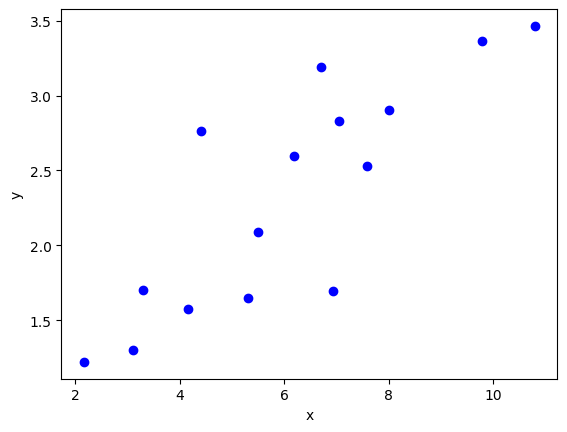

In [10]:
# Create a toy dataset (we store all values of x and y into single tensors 'all_x' and 'all_y')
all_x = torch.tensor([[3.3], [4.4], [5.5], [6.71], [6.93], [4.168], [9.779], [6.182], [7.59],
                      [2.167], [7.042], [10.791], [5.313], [7.997], [3.1]], dtype=torch.float)
all_y = torch.tensor([[1.7], [2.76], [2.09], [3.19], [1.694], [1.573], [3.366], [2.596], [2.53],
                      [1.221], [2.827], [3.465], [1.65], [2.904], [1.3]], dtype=torch.float)
print(all_x.shape, all_y.shape)

# Plot the data (y as a function of x)
plt.figure()
plt.plot(all_x, all_y, 'bo')
plt.xlabel('x'), plt.ylabel('y')
plt.show()

The data tensors `all_x` and `all_y` we have defined here constitute our *dataset*, which has therefore a length of 15; and each data sample $(x,y)$ is one element in `(all_x,all_y)`. Since it's a very small and simple dataset, we don't need to use a Pytorch `Dataset` or `Dataloader` object as introduced in lab 1; we can directly consider that our dataset consists of 1 batch of data, with a batch size of 15.

### Model

Let us create our linear model. In pytorch, it's easily done with `nn.Linear` (check the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=torch%20nn%20linear#torch.nn.Linear)!). In particular, we need to specify the input and output sizes. In our case, these are equal to 1 since we work with scalars. There is also an option `bias` which can be `True` (default) or `False`. If `bias=False`, then $b=0$ and the model reduces to $f(x) = wx$.

**Note**: When we create a Pytorch model using any `torch.nn` module, the corresponding parameters have `requires_grad=True` by default, thus you don't need to explicitly specify it.

In [11]:
# Create the linear model
input_size = 1
output_size = 1
lin_reg_model = nn.Linear(input_size, output_size, bias=True)

# 'lin_reg_model' is a module which contains the linear function and its parameters (weight and bias)
# When we instanciate the model, the parameters are initialized with random values
# We also remark that both parameters have 'requires_grad=True', which is the normal default behavior.
print(lin_reg_model.weight)
print(lin_reg_model.bias)

Parameter containing:
tensor([[0.8070]], requires_grad=True)
Parameter containing:
tensor([-0.3375], requires_grad=True)


In [12]:
# If you only want to display the value of the parameters, use the '.item()' method
print(lin_reg_model.weight.item())
print(lin_reg_model.bias.item())

0.806978702545166
-0.3374825716018677


In [13]:
# Now we can easily compute predictions as y_pred = f(x) as follows:
x = all_x[0]
y_pred = lin_reg_model(x)
print(y_pred)

# Since y_pred is computed from the model (which has requires_grad=True), it also has requires_grad=True
print(y_pred.requires_grad)

tensor([2.3255], grad_fn=<ViewBackward0>)
True


False


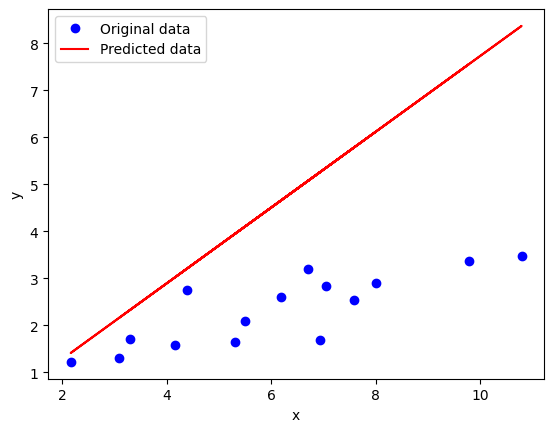

In [14]:
# Let's compute predictions for all the data at once:
all_y_pred = lin_reg_model(all_x)

# If we want to plot all_y_pred, we first need to get rid of the tracked gradient. This is done as follows:
all_y_pred = all_y_pred.detach()
print(all_y_pred.requires_grad)

# We can plot the predicted values on top of the original data
plt.figure()
plt.plot(all_x, all_y, 'bo', label='Original data')
plt.plot(all_x, all_y_pred, 'r', label='Predicted data')
plt.xlabel('x'), plt.ylabel('y')
plt.legend()
plt.show()

In [15]:
# It is possible to manually change the values of the parameters (weight and bias):
lin_reg_model.weight.data.fill_(2)
lin_reg_model.bias.data.fill_(3)

print(lin_reg_model.weight)
print(lin_reg_model.bias)

Parameter containing:
tensor([[2.]], requires_grad=True)
Parameter containing:
tensor([3.], requires_grad=True)


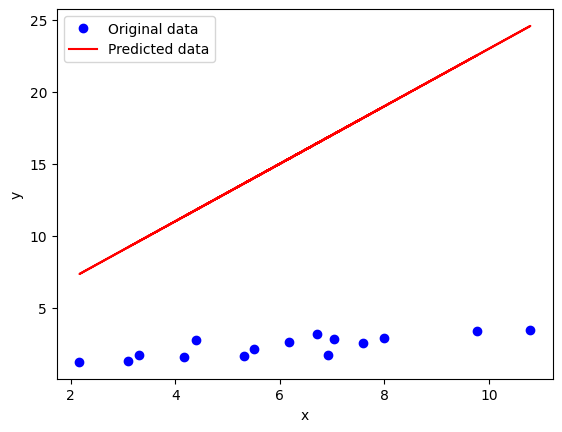

In [16]:
# TO DO:
# - set the weight and bias of the linear model at 0.5 and -1, respectively.
lin_reg_model.weight.data.fill_(2)
lin_reg_model.bias.data.fill_(3)
# - compute the new predictions all_y_pred with this model
all_y_pred = lin_reg_model(all_x)

# stop tracking the gradient
all_y_pred = all_y_pred.detach()

# - plot the predictions on top of the original data
plt.figure()
plt.plot(all_x, all_y, 'bo', label='Original data')
plt.plot(all_x, all_y_pred, 'r', label='Predicted data')
plt.xlabel('x'), plt.ylabel('y')
plt.legend()
plt.show()

### Training

Now that our model is defined, we have to train it, that is, to optimize the values of the weight and bias $w$ and $b$. To do that, we first define the [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions) and the `optimizer` (i.e., [the optimization algorithm](https://pytorch.org/docs/stable/optim.html#algorithms)).

In [17]:
# TO DO: first, re-instanciate the model and set both the weight and bias at 1.
lin_reg_model = nn.Linear(input_size, output_size, bias=True)
lin_reg_model.weight.data.fill_(1)
lin_reg_model.bias.data.fill_(1)
# This will avoid random values and ensure reproducibility (everyone should get the same results)
print(lin_reg_model.weight.item())
print(lin_reg_model.bias.item())


1.0
1.0


In [18]:
# For linear regression, it is common to use the mean square error (MSE) as loss function
loss_fn = nn.MSELoss() 

# For the optimizer, let's use stochastic gradient (SGD). In Pytorch, we need to specify:
# - which parameters are going to be updated (= the model's parameters)
# - the learning rate
optimizer = torch.optim.SGD(lin_reg_model.parameters(), lr=0.01)

Let us briefly recap the gradient descent procedure for training (we note $\mathcal{L}$ the loss function and $\mu$ the learning rate). At each iteration (or *epoch*), we perform the following operations:
1. Using the current model's parameters, compute the predictions: $y_{\text{pred}} = f(x)$
2. Using the loss function, compute the error between true values and predictions: $l = \mathcal{L}(y_{\text{pred}},y)$
3. Compute the gradients of the loss with respect to the parameters. If there are only two parameters $w$ and $b$, then we have to compute $\nabla_{w} l$ and $\nabla_{b} l$.
4. Perform gradient descent, that is, update the parameters with: $w \leftarrow w - \mu \nabla_{w} l$ and $b \leftarrow b - \mu \nabla_{b} l$

The good news is that we don't have to explicitly code steps 3. and 4., since Pytorch takes care about that for us with simple functions: all gradients are computed with `l.backward()` (we have seen this one already) and the gradient descent is simply performed with `optimizer.step()`.

**Note**: before computing the gradients with `l.backward()`, it's safer to remove all possible gradients that have been computed beforehand (e.g., from another model, or stored in the memory) to avoid numerical issues. This is easily done with: `optimizer.zero_grad()`.

<span style="color:red">**Exercice 2**</span> Write the training loop for 10 epochs. At the end of each epoch, print the value of the loss (it's easily accessed with `l.item()`). After training, print the final values of the weight $w$ and bias $b$.

In [19]:
epochs = 10
for epoch in range(epochs):
    # predictions
    y_pred = lin_reg_model(all_x)
    loss = loss_fn(y_pred, all_y)

    # Compute gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

print("Final weight: ", (lin_reg_model.weight.item()))
print("Final bias: ", (lin_reg_model.bias.item()))

Epoch 1/10, Loss: 25.676067352294922
Epoch 2/10, Loss: 0.6435868144035339
Epoch 3/10, Loss: 0.18030418455600739
Epoch 4/10, Loss: 0.17171698808670044
Epoch 5/10, Loss: 0.17154482007026672
Epoch 6/10, Loss: 0.17152836918830872
Epoch 7/10, Loss: 0.17151494324207306
Epoch 8/10, Loss: 0.17150162160396576
Epoch 9/10, Loss: 0.17148835957050323
Epoch 10/10, Loss: 0.1714751422405243
Final weight:  0.2399560809135437
Final bias:  0.8870622515678406


### Vizualization

After training, you can use the trained model to compute the final estimates `all_y_pred`, and compare them to the original data. It is useful to vizualise whether the model properly fits the data or not.

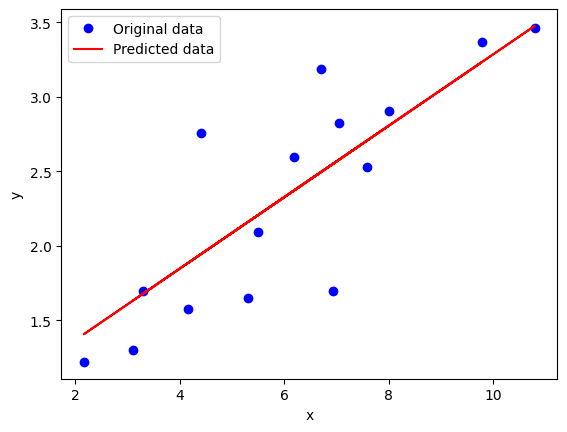

In [20]:
# TO DO: Compute the final estimates all_y_pred using the trained model, and plot the results (original data and predictions)
all_y_pred = lin_reg_model(all_x)
all_y_pred = all_y_pred.detach()

# plot results
plt.figure()
plt.plot(all_x, all_y, 'bo', label='Original data')
plt.plot(all_x, all_y_pred, 'r', label='Predicted data')
plt.xlabel('x'), plt.ylabel('y')
plt.legend()
plt.show()


Congrats, you have just trained and saved your first model in Pytorch! In practice, this is how easy working with neural networks is, and the training function is always pretty much the same, up to one difference: here he have use the whole dataset (`all_x`) directly, but real-world datasets are much larger, so we need to split it into batches using a `Dataloader` (as we've seen in lab 1), and iterate over these batches (as we will see in lab 3).

### Saving and loading a model

You can save a trained model in an external file in order to reuse it later (e.g., evaluate it in a separate script, resume training, fine-tune it on a different dataset, share it with other developpers, etc.). In PyTorch, you can either save the *whole model*, which includes all its architecture details; or only the *model's parameters* (weights and biases). The latter is the [recommended way](https://pytorch.org/tutorials/beginner/saving_loading_models.html).


In [21]:
# Save the trained model's parameters
torch.save(lin_reg_model.state_dict(), 'model_linear_regression.pt')

In [22]:
# To load it, you need to first instanciate a model using the class definition, and then load the parameters
loaded_model = nn.Linear(input_size, output_size, bias=True)
loaded_model.load_state_dict(torch.load('model_linear_regression.pt'))

# Print the value of the weight and bias to check it's the same as when finishing training above
print('weight after loading the trained model:', loaded_model.weight.item())
print('bias after loading the trained model:', loaded_model.bias.item())

weight after loading the trained model: 0.2399560809135437
bias after loading the trained model: 0.8870622515678406


/tmp/ipykernel_6371/1706917576.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('model_linear_regression.pt'))


## Nonlinear regression

We now address the more elaborate task of *nonlinear regression*, where $f$ is no longer a simple linear/affine function.

<center><a href="https://www.r-bloggers.com/2016/02/first-steps-with-non-linear-regression-in-r/">
    <img src="https://i0.wp.com/datascienceplus.com/wp-content/uploads/2016/02/NLS_2.png" width="400"></a></center>

In some scenarios, analyzing/vizualizing the data allows to recognize the nature of $f$ (polynomial, exponential, logarithm...). But sometimes, things get more complicated and even vizualization is not straightforward (e.g., when working with high-dimensional data such as images, audio signals, text data...). That's where neural networks become useful: we only define a general function architecture by assembling elementary operators (linear layers and *activation functions*), which allows to approximate any complicated function (remember the [universal approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)).

### Data

For this example, we consider sinusoidal-like data - of course in this case we know the function $f$, but let's pretend we don't and see if we can approximate it using a neural network.

torch.Size([60, 1])


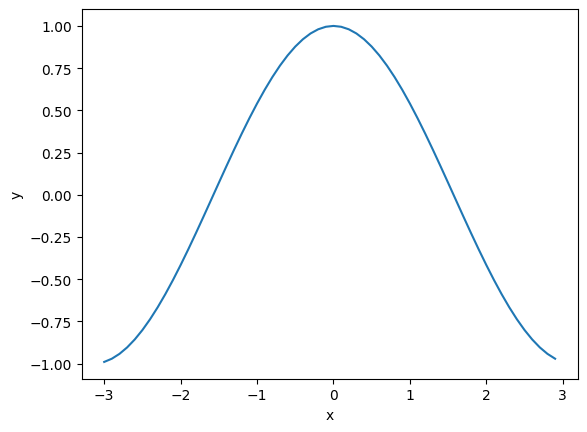

In [23]:
# TO DO: generate sinusoidal data:
# - create a tensor all_x which ranges from -3 to 3 with a step of 0.1
all_x = torch.arange(-3, 3, 0.1)
# - unsqueeze it to add an extra dimension (its shape should be [60, 1])
all_x = all_x.unsqueeze(1)
print(all_x.shape)
# - compute all_y = cos(all_x)
all_y = torch.cos(all_x)
# - plot all_y as a function of all_x
plt.figure()
plt.plot(all_x, all_y)
plt.xlabel('x'), plt.ylabel('y')
plt.show()


### Model

As recalled above, the core idea behind neural networks is to assemble simple mathematical operations to approximate a potentially complicated function. For instance, in multilayer perceptrons (MLP), a network is designed by concatenating several layers, where each layer consists of:
- a linear function
- (potentially) a non-linear element-wise *activation* function

There is a plethora of nonlinear activation functions, which you can check [here](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). A popular one is the rectified linear unit ([ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)).

Here, we propose to approximate our sinusoidal data with a simple network made up with 2 linear layers and 1 activation function in between:

<center> $x \to$ Linear_1 $\to$ ReLU $\to$ Linear_2 $\to y$</center>
&nbsp;

where the first linear layer increases the dimension (`input_size=1` and `output_size=3`) and the second linear layer decreases the dimension (input and output sizes are inverted). To build the complete model, you can stack the separate layers together into one model using the [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) function.

In [24]:
# TO DO: write the 'nonlin_reg_model' model described above.4
non_linear_model = nn.Sequential(
    nn.Linear(1, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
)
# When it's done, compute nonlin_reg_model(all_x) to be sure there are no bugs
nonlin_y_pred = non_linear_model(all_x)
print(nonlin_y_pred.shape)


torch.Size([60, 1])


In [25]:
# initialization (ensure reproducibility: everybody should have the same results)
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)

torch.manual_seed(0)
non_linear_model.apply(init_weights)

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
)

### Training

The training procedure is similar to the linear regression case we handled before. We use the MSE function, 50 epochs, and the algorithm is SGD with a learning rate of 0.1.

**Note**: Every time you train a new model, you need to define a new optimizer, in order to make sure you're updating the parameters of this new model (here: `nonlin_reg_model`). Otherwise, you will likely be optimizing the parameters of the previous model...

In [26]:
# Training parameters
num_epochs = 50
loss_fn = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(non_linear_model.parameters(), lr=0.1)

<span style="color:red">**Exercice 3**</span> Write the training loop for the nonlinear model, and store the loss over epochs into a list. After training, save the model's parameters and plot the loss over epochs.

In [27]:
l = []
for epoch in range(num_epochs):
    # prediction
    nonlin_y_pred = non_linear_model(all_x)
    loss = loss_fn(nonlin_y_pred, all_y)

    # Compute gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

    # save model parameters to a file
    torch.save(non_linear_model.state_dict(), 'model_non_linear_regression.pth')

    l.append(loss.item())
print(l)

final_weight = non_linear_model[0].weight.data
final_bias = non_linear_model[0].bias.data


[1.1615878343582153, 0.45548325777053833, 0.3299216032028198, 0.2717095613479614, 0.23716576397418976, 0.2123541533946991, 0.19228552281856537, 0.17489390075206757, 0.1596374809741974, 0.14655303955078125, 0.13501644134521484, 0.1244826689362526, 0.1147155687212944, 0.10563235729932785, 0.09718477725982666, 0.08933684229850769, 0.08205673843622208, 0.07531407475471497, 0.06909704953432083, 0.06337191164493561, 0.05809176340699196, 0.053229983896017075, 0.04877268522977829, 0.044678859412670135, 0.0409226156771183, 0.0374780036509037, 0.034327466040849686, 0.03145235404372215, 0.028836945071816444, 0.0264514721930027, 0.024277925491333008, 0.02229941077530384, 0.020500140264630318, 0.01886533945798874, 0.017381254583597183, 0.01603510230779648, 0.014815015718340874, 0.013710846193134785, 0.012715236283838749, 0.011814242228865623, 0.010999348014593124, 0.010262721218168736, 0.009597196243703365, 0.008996174670755863, 0.008453640155494213, 0.007964090444147587, 0.007522496860474348, 0.00

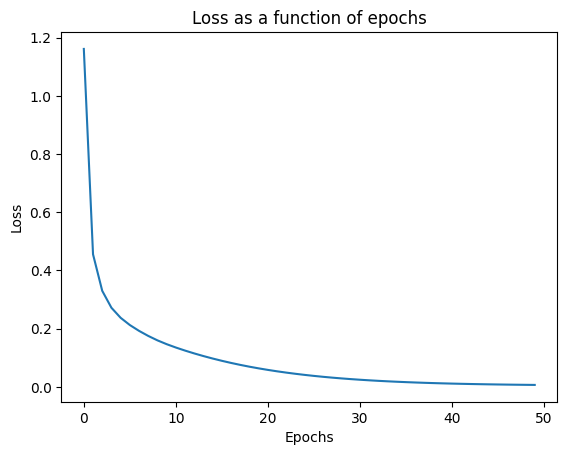

In [28]:
# Plot loss as a function of epochs
loss = torch.arange(0, len(l), 1)
plt.figure()
plt.plot(loss, l)
plt.xlabel('Epochs'), plt.ylabel('Loss')
plt.title('Loss as a function of epochs')
plt.show()

<span style="color:red">**Exercice 4**</span> Use the trained model to compute the predicted outputs, and plot the results (original data and predicted outputs).

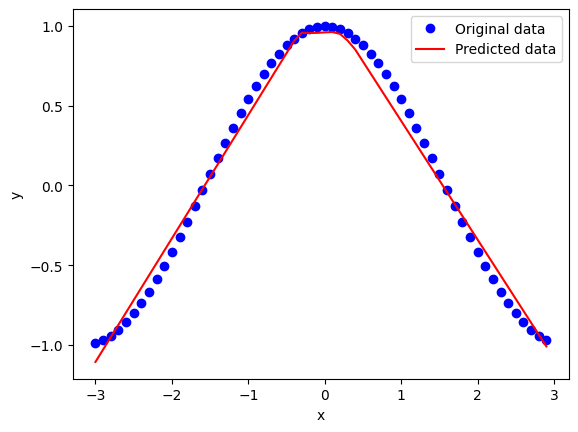

In [29]:
nonlin_y_pred = non_linear_model(all_x)
nonlin_y_pred = nonlin_y_pred.detach()

# plot results
plt.figure()
plt.plot(all_x, all_y, 'bo', label='Original data')
plt.plot(all_x, nonlin_y_pred, 'r', label='Predicted data')
plt.xlabel('x'), plt.ylabel('y')
plt.legend()
plt.show()